Processing file: https://raw.githubusercontent.com/WolfgangDrescher/lassus-geistliche-psalmen/master/kern/08-domine-dominus-noster.krn



,Measure,Local Onset,Global Onset,Duration,Pitch,MIDI
0,1,0.0,0.0,4.0,D5,74
1,1,2.0,2.0,2.0,D4,62
2,1,4.0,4.0,2.0,D5,74
3,1,4.0,4.0,1.0,D4,62
4,1,5.0,5.0,1.0,E4,64
...,...,...,...,...,...,...
227,22,6.0,174.0,2.0,C#4,61
228,22,6.0,174.0,2.0,A3,57
229,23,0.0,176.0,8.0,F#4,66
230,23,0.0,176.0,8.0,D4,62


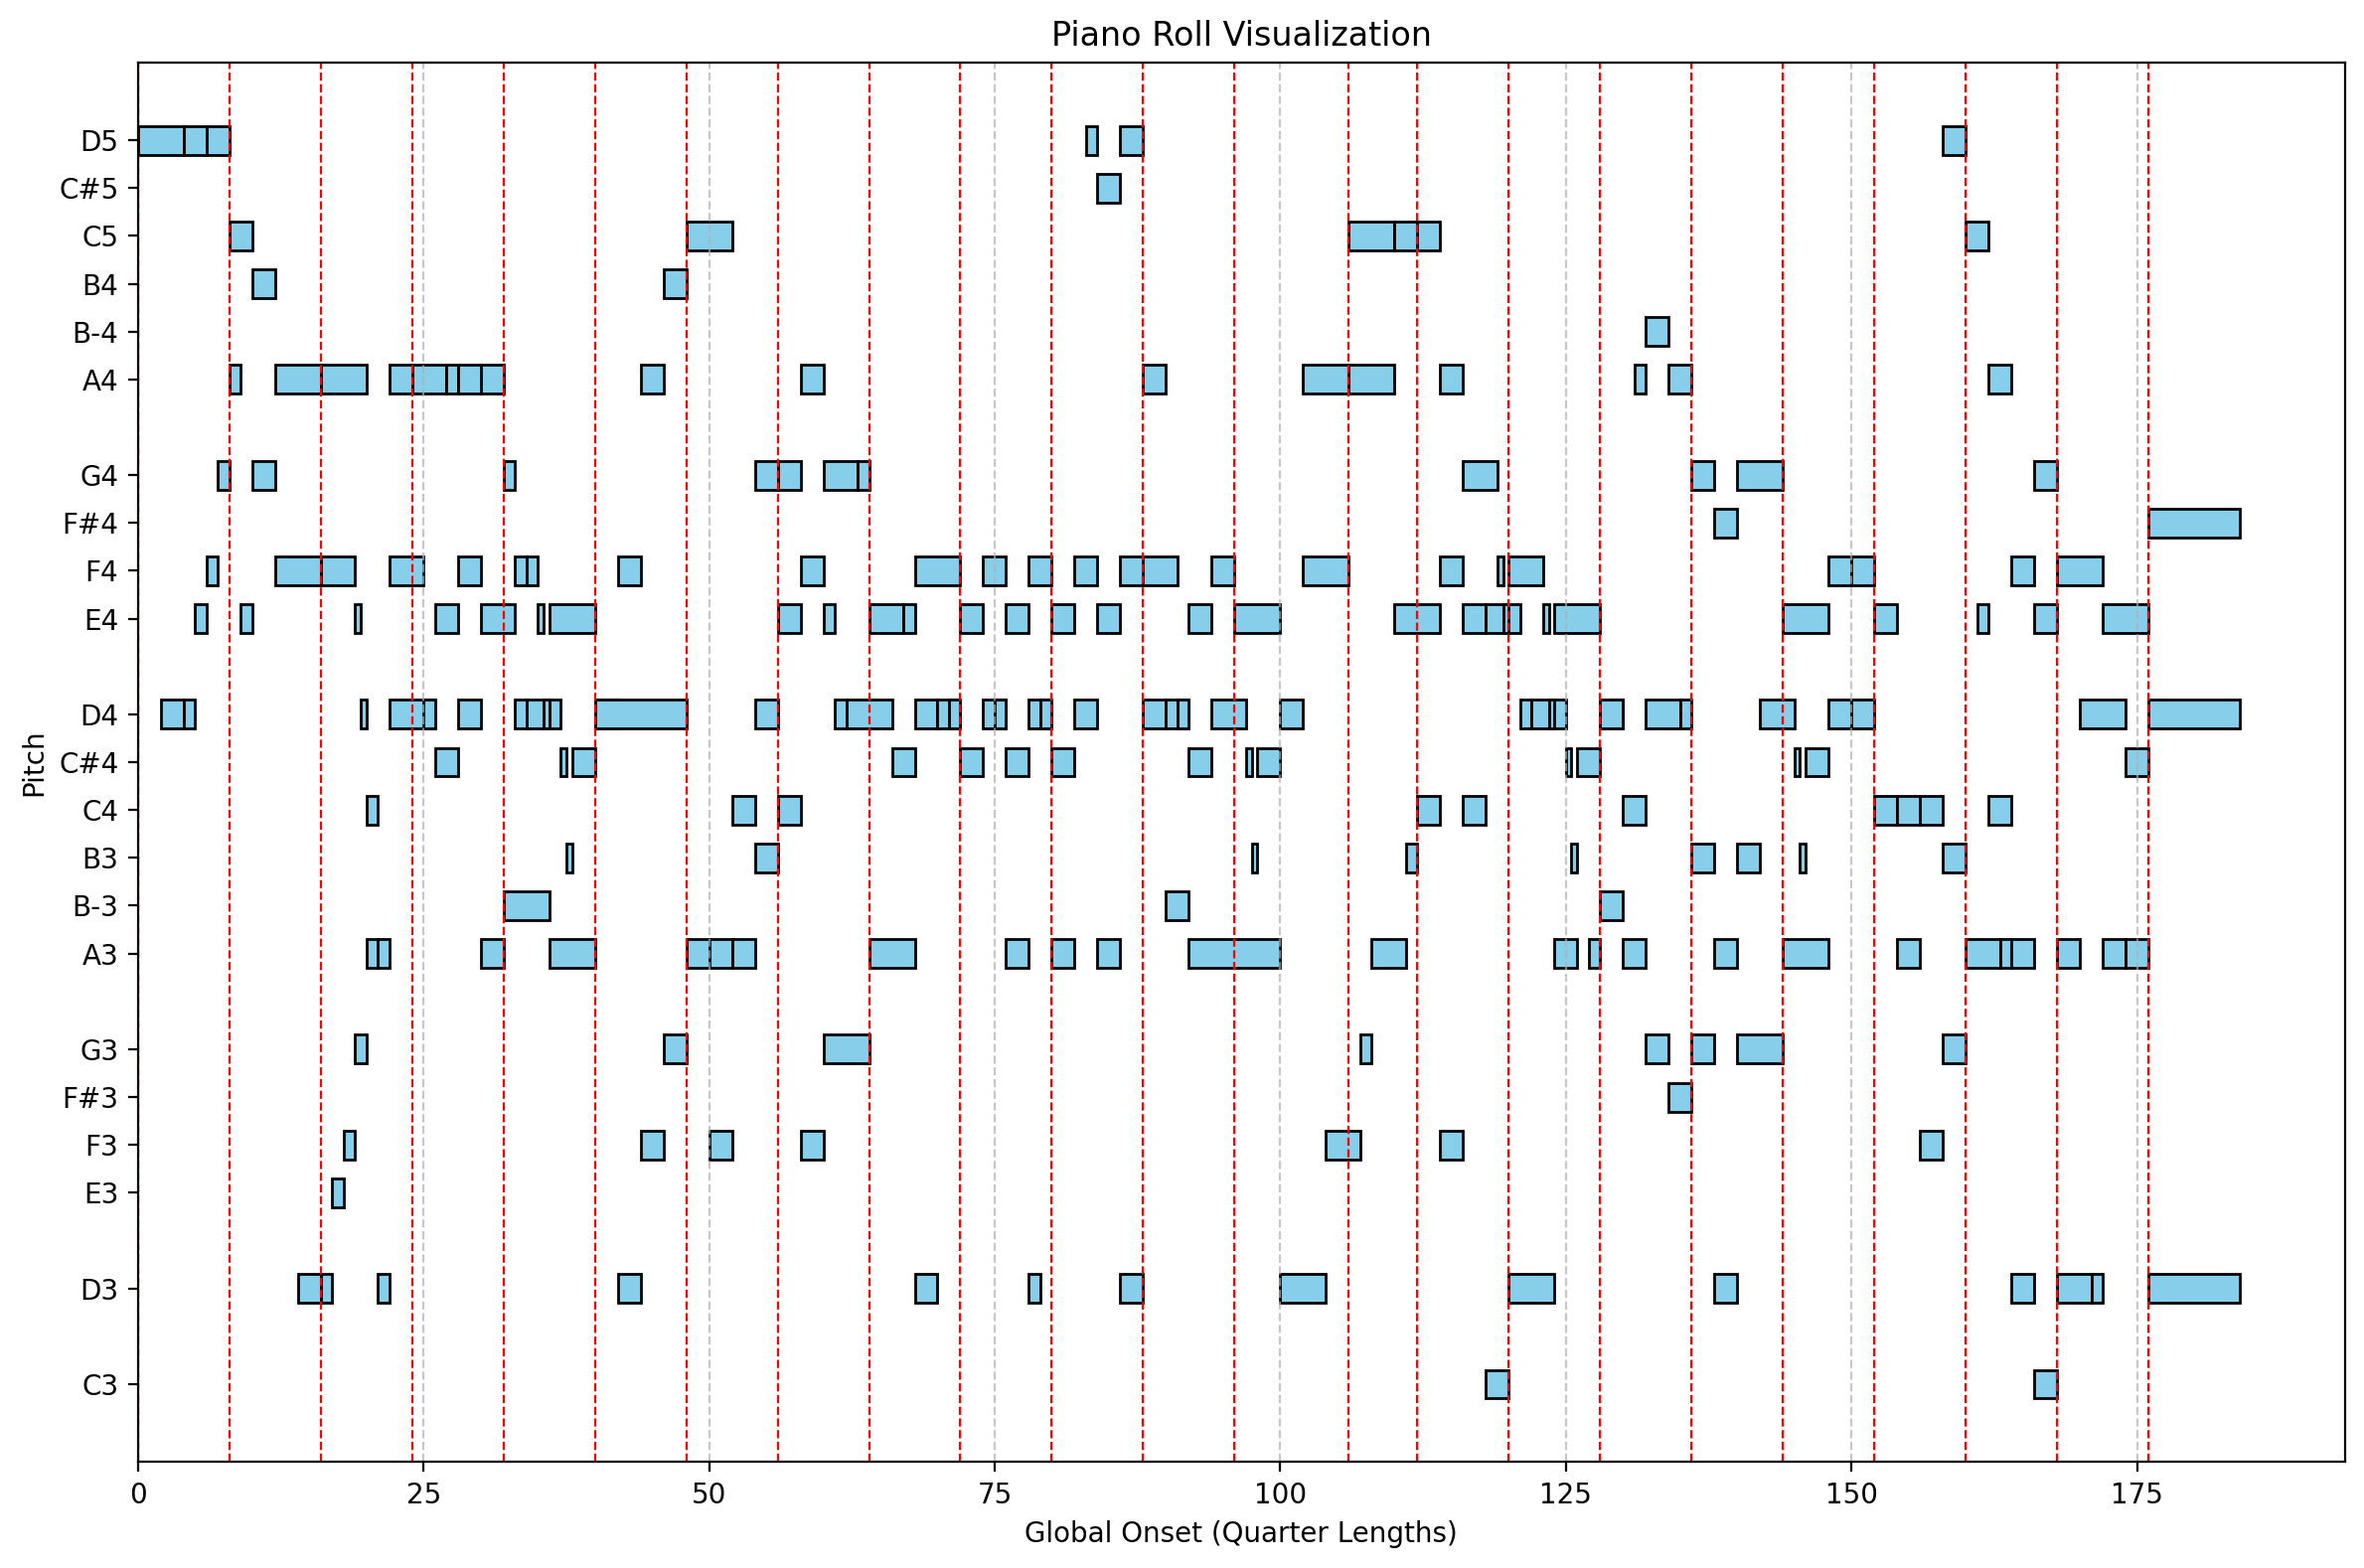

In [1]:
# Import necessary libraries
import os
import tempfile
import requests
import pandas as pd
import matplotlib.pyplot as plt
from music21 import converter, note, chord, pitch as pitch_module
from IPython.display import display

# Function to get the local file path from a URL or verify a local path
def get_file_path(file_source):
    """
    Determines if file_source is a URL or a local path.
    Downloads the file if it's a URL and returns the local path.
    Verifies and returns the path if it's a local file.

    Parameters
    ----------
    file_source : str
        URL or local file path.

    Returns
    -------
    str
        Local file path.

    Raises
    ------
    ValueError
        If there's an issue downloading the file.
    FileNotFoundError
        If the local file does not exist.
    """
    if file_source.startswith(('http://', 'https://')):
        try:
            response = requests.get(file_source, stream=True)
            response.raise_for_status()
            _, file_extension = os.path.splitext(file_source)
            temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=file_extension)
            with temp_file as tf:
                tf.write(response.content)
            return temp_file.name
        except requests.RequestException as e:
            raise ValueError(f"Error downloading the file: {e}")
    else:
        if os.path.exists(file_source):
            return file_source
        else:
            raise FileNotFoundError(f"Local file does not exist: {file_source}")

# Function to extract voice data from the score
def extract_voice_data(score):
    """
    Extracts measure number, global onset, local onset, duration, and pitch from a music21 score.

    Parameters
    ----------
    score : music21.stream.Score
        The music21 score object.

    Returns
    -------
    list of tuples
        Each tuple contains (Measure, Local Onset, Global Onset, Duration, Pitch).
    """
    voice_data = []
    notes_and_chords = score.flatten().notesAndRests.stream()

    for element in notes_and_chords:
        if isinstance(element, (note.Note, chord.Chord)):
            # Get the measure context
            measure = element.getContextByClass('Measure')
            if measure is not None:
                measure_num = measure.number
                measure_offset = measure.offset
            else:
                # If measure context is not found, default to 0
                measure_num = 0
                measure_offset = 0.0

            global_onset = element.offset
            local_onset = global_onset - measure_offset
            duration = element.duration.quarterLength

            # Handle notes and chords
            if isinstance(element, note.Note):
                pitches = [str(element.pitch)]
            else:
                pitches = [str(p) for p in element.pitches]

            # Append data for each pitch
            voice_data.extend([
                (measure_num, local_onset, global_onset, duration, pitch)
                for pitch in pitches
            ])

    return voice_data

# Function to create a piano roll plot with measure lines
def create_piano_roll(df, measure_offsets=None):
    """
    Generates a piano roll visualization from the DataFrame.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing 'Measure', 'Local Onset', 'Global Onset', 'Duration', 'Pitch', and 'MIDI'.
    measure_offsets : list of floats, optional
        List of global onset times where measures start. If provided, vertical lines will be drawn at these positions.
    """
    # Ensure unique MIDI to pitch mapping
    midi_to_pitch = df.drop_duplicates('MIDI').set_index('MIDI')['Pitch'].to_dict()

    plt.figure(figsize=(12, 8))
    for _, row in df.iterrows():
        plt.barh(
            row['MIDI'],
            width=row['Duration'],
            left=row['Global Onset'],
            height=0.6,
            color='skyblue',
            edgecolor='black'
        )

    plt.yticks(list(midi_to_pitch.keys()), list(midi_to_pitch.values()))
    plt.xlabel('Global Onset (Quarter Lengths)')
    plt.ylabel('Pitch')
    plt.title('Piano Roll Visualization')

    # Draw measure lines if measure offsets are provided
    if measure_offsets is not None:
        for m_offset in measure_offsets:
            plt.axvline(x=m_offset, color='red', linestyle='--', linewidth=0.8)

    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Function to filter and adjust durations in the DataFrame
def filter_and_adjust_durations(df, filter_zero_duration=True, adjust_fractional_duration=True):
    """
    Filters out zero-duration notes and adjusts fractional durations.

    Parameters
    ----------
    df : pandas.DataFrame
        Original DataFrame.
    filter_zero_duration : bool, optional
        If True, removes rows with Duration <= 0. Default is True.
    adjust_fractional_duration : bool, optional
        If True, rounds 'Duration', 'Local Onset', and 'Global Onset' to 3 decimal places. Default is True.

    Returns
    -------
    pandas.DataFrame
        Processed DataFrame.
    """
    df_processed = df.copy()

    if filter_zero_duration:
        df_processed = df_processed[df_processed['Duration'] > 0]

    if adjust_fractional_duration:
        df_processed['Duration'] = df_processed['Duration'].round(3)
        df_processed['Local Onset'] = df_processed['Local Onset'].round(3)
        df_processed['Global Onset'] = df_processed['Global Onset'].round(3)

    return df_processed

# Configuration flags
FILTER_ZERO_DURATION = True        # Set to False to include zero-duration notes
ADJUST_FRACTIONAL_DURATION = True  # Set to False to keep original durations

# List of file sources (URLs or local paths)
file_sources = [
    #'https://analyse.hfm-weimar.de/database/02/PrJode_Jos0302_COM_1-5_MissaDapac_002_00006.xml',
    #'https://raw.githubusercontent.com/humdrum-tools/bach-wtc-fugues/refs/heads/master/kern/wtc1f01.krn',
    'https://raw.githubusercontent.com/WolfgangDrescher/lassus-geistliche-psalmen/master/kern/08-domine-dominus-noster.krn'
    #'https://raw.githubusercontent.com/music-encoding/sample-encodings/main/MEI_5.0/Music/Complete_examples/Bach-JS_Ein_feste_Burg.mei'
    # Add more file sources as needed
]

# Processing loop
for file_source in file_sources:
    try:
        print(f"Processing file: {file_source}\n")

        # Get the local file path
        file_path = get_file_path(file_source)

        # Parse the music file
        score = converter.parse(file_path)

        # Extract voice data
        voice_data = extract_voice_data(score)

        # Create DataFrame with specified column order
        df = pd.DataFrame(voice_data, columns=['Measure', 'Local Onset', 'Global Onset', 'Duration', 'Pitch'])
        df = df[['Measure', 'Local Onset', 'Global Onset', 'Duration', 'Pitch']]

        # Convert Pitch to MIDI with error handling
        try:
            df['MIDI'] = df['Pitch'].apply(lambda x: pitch_module.Pitch(x).midi)
        except Exception as e:
            print(f"Error converting pitch to MIDI: {e}")
            continue

        # Process the DataFrame
        df_processed = filter_and_adjust_durations(
            df,
            filter_zero_duration=FILTER_ZERO_DURATION,
            adjust_fractional_duration=ADJUST_FRACTIONAL_DURATION
        )

        # Display the processed DataFrame
        display(df_processed)

        # Get measure offsets for drawing measure lines
        # Assuming all parts have the same measure structure
        measures = score.parts[0].getElementsByClass('Measure')
        measure_offsets = [measure.offset for measure in measures]

        # Create the piano roll visualization with measure lines
        create_piano_roll(df_processed, measure_offsets=measure_offsets)

        # Optionally, delete the temporary file if it was downloaded
        if file_source.startswith(('http://', 'https://')):
            os.remove(file_path)

    except Exception as e:
        print(f"An error occurred while processing {file_source}: {e}\n")


Using automatic resolution based on smallest duration: 0.5
Total duration: 184.0, Number of columns: 368


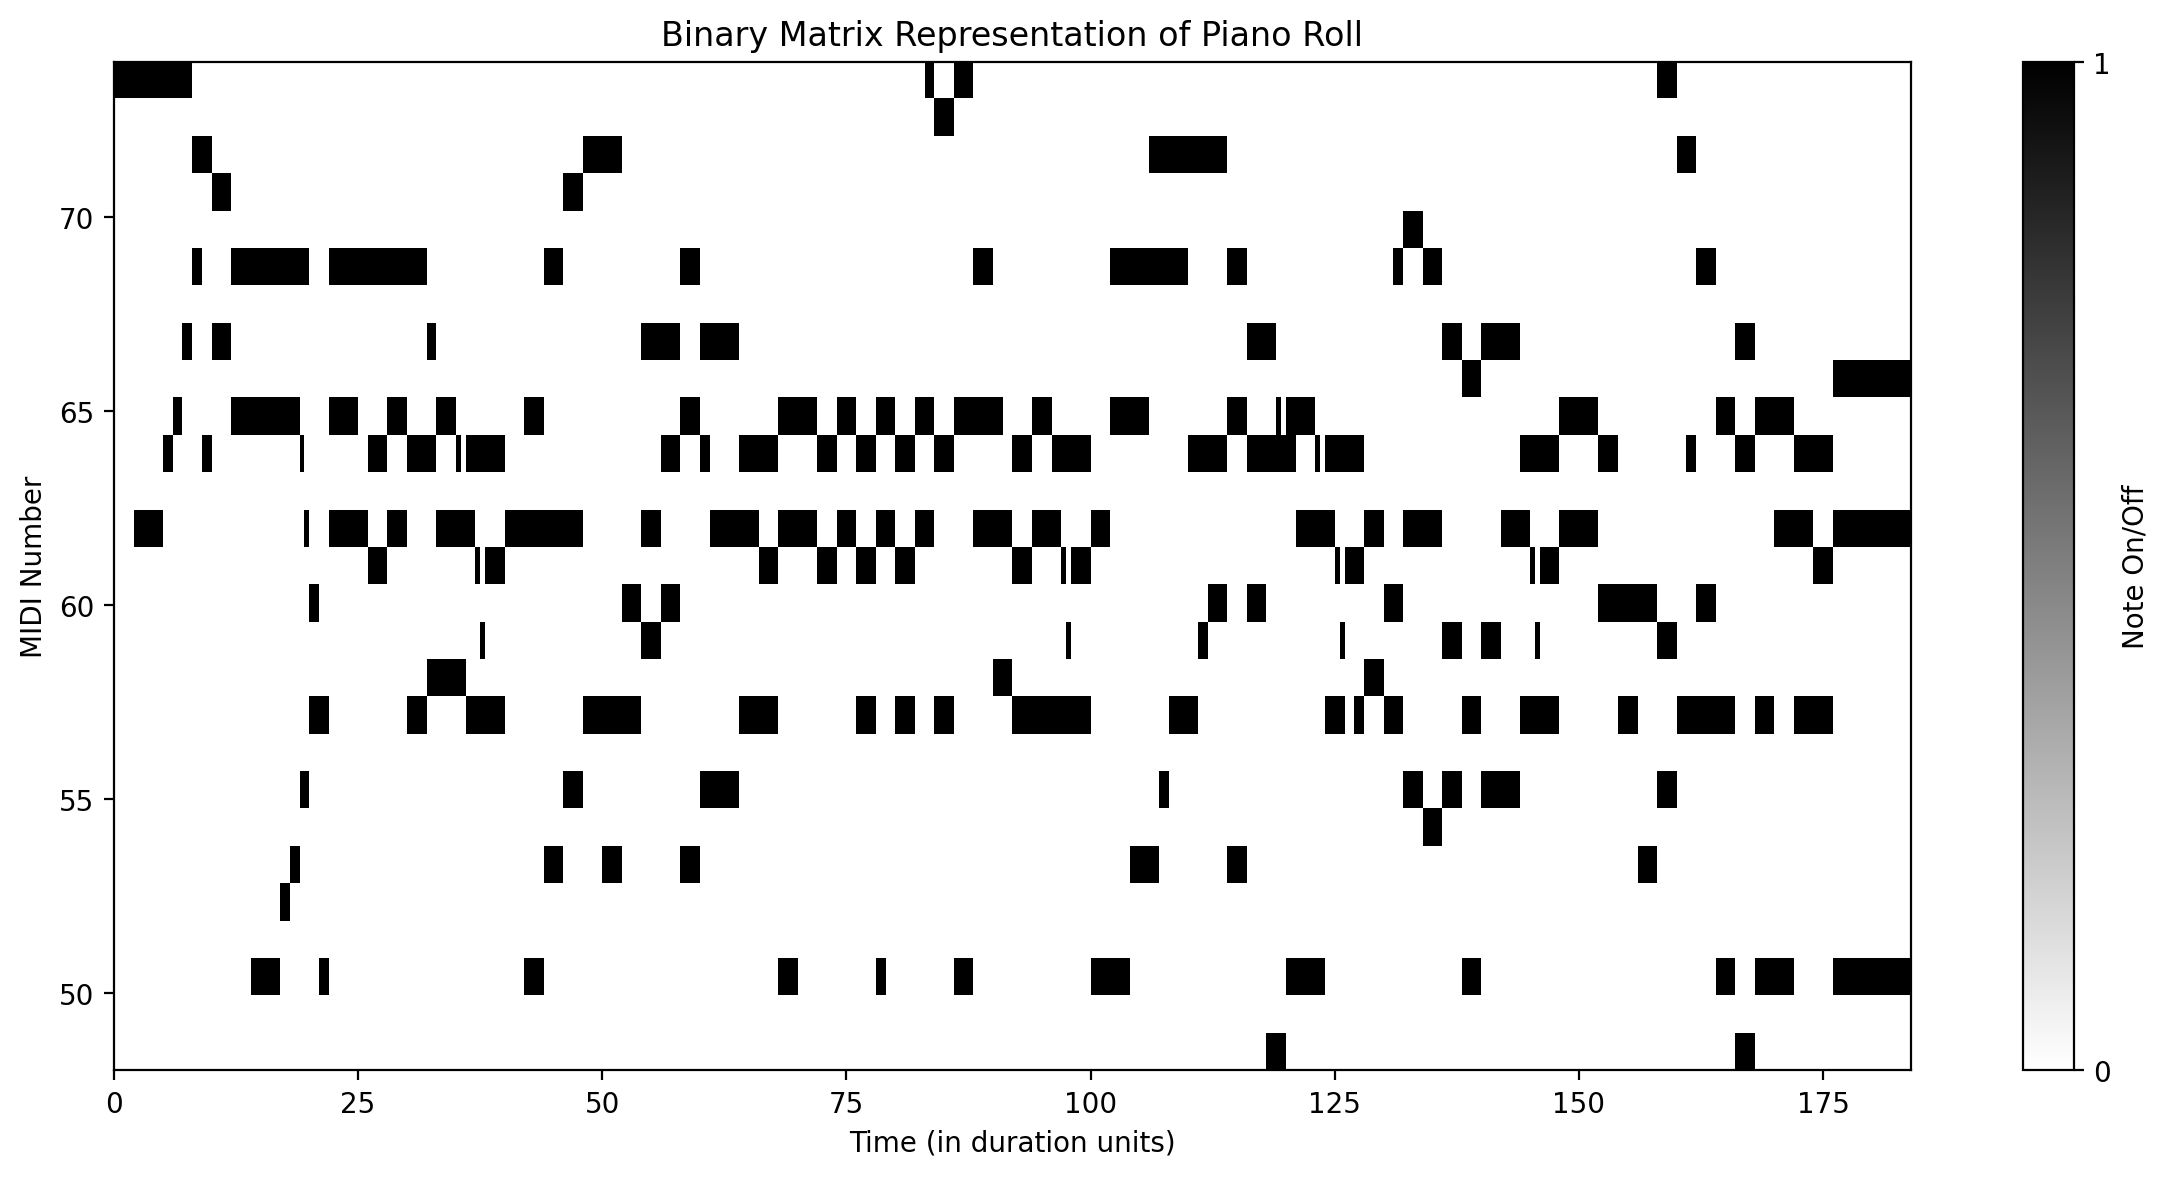

Dimensions of binary matrix: (27, 368)
Binary Matrix:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def create_binary_matrix(df_processed, resolution_method='auto', manual_resolution=None):
    """
    Converts a dataframe with parsed symbolic music information into a binary matrix.

    Parameters:
    - df_processed (pd.DataFrame): DataFrame containing music information with at least 'MIDI',
                                    'Duration', and 'Global Onset' columns.
    - resolution_method (str): Method to determine time resolution.
                               Options: 'auto', 'manual', 'standard'
    - manual_resolution (float): The smallest duration unit to use if resolution_method is 'manual'.

    Returns:
    - binary_matrix (np.ndarray): Binary matrix representation of the piano roll.
    - lowest_midi (int): Lowest MIDI number in the data.
    - highest_midi (int): Highest MIDI number in the data.
    - num_cols (int): Number of time columns in the binary matrix.
    - resolution (float): Time resolution used.
    """
    # Step 1: Identify the range of pitches (Y-axis)
    lowest_midi = df_processed['MIDI'].min()
    highest_midi = df_processed['MIDI'].max()

    # Step 2: Determine the resolution (X-axis)
    if resolution_method == 'auto':
        resolution = df_processed['Duration'].min()
        print(f"Using automatic resolution based on smallest duration: {resolution}")
    elif resolution_method == 'manual':
        if manual_resolution is None:
            raise ValueError("manual_resolution must be provided when resolution_method is 'manual'.")
        resolution = manual_resolution
        print(f"Using manual resolution: {resolution}")
    elif resolution_method == 'standard':
        # Example of a standard musical resolution (e.g., 16th note if tempo is known)
        # Here, you might define a standard resolution based on musical context
        # For demonstration, let's assume a fixed standard resolution
        resolution = 0.25  # Example: quarter note in beats
        print(f"Using standard resolution: {resolution}")
    else:
        raise ValueError("Invalid resolution_method. Choose from 'auto', 'manual', 'standard'.")

    # Validate that resolution is positive
    if resolution <= 0:
        raise ValueError("Resolution must be a positive number.")

    # Calculate the total duration of the piece
    total_duration = df_processed['Global Onset'].max() + df_processed['Duration'].max()

    # Number of columns is total duration divided by resolution
    num_cols = int(np.ceil(total_duration / resolution))
    print(f"Total duration: {total_duration}, Number of columns: {num_cols}")

    # Step 3: Initialize a binary matrix
    binary_matrix = np.zeros((highest_midi - lowest_midi + 1, num_cols), dtype=int)

    # Step 4: Fill in the binary matrix
    for index, row in df_processed.iterrows():
        # Calculate the row corresponding to the MIDI number
        row_index = row['MIDI'] - lowest_midi

        # Calculate the columns corresponding to the Global Onset and Duration
        start_col = int(np.floor(row['Global Onset'] / resolution))
        end_col = int(np.ceil((row['Global Onset'] + row['Duration']) / resolution))

        # Handle edge cases where end_col might exceed num_cols
        end_col = min(end_col, num_cols)

        # Set the appropriate elements to 1
        binary_matrix[row_index, start_col:end_col] = 1

    # Visualization
    plt.figure(figsize=(12, 6))
    extent = [0, num_cols * resolution, lowest_midi, highest_midi]
    plt.imshow(binary_matrix, aspect='auto', origin='lower', cmap='gray_r', extent=extent)
    plt.xlabel('Time (in duration units)')
    plt.ylabel('MIDI Number')
    plt.title('Binary Matrix Representation of Piano Roll')
    plt.colorbar(label='Note On/Off', ticks=[0, 1])
    plt.tight_layout()
    plt.show()

    # Print matrix dimensions
    matrix_dimensions = binary_matrix.shape
    print(f'Dimensions of binary matrix: {matrix_dimensions}')

    # Set numpy print options to display the full array (adjust as needed)
    np.set_printoptions(threshold=1000, linewidth=100)

    # Print the binary matrix
    print('Binary Matrix:\n', binary_matrix)

    return binary_matrix, lowest_midi, highest_midi, num_cols, resolution

# Example Usage:
# Automatic resolution based on smallest duration
binary_matrix_auto, low_midi, high_midi, cols_auto, res_auto = create_binary_matrix(df_processed, resolution_method='auto')

# # Manual resolution (e.g., 0.5 time units)
# binary_matrix_manual, low_midi, high_midi, cols_manual, res_manual = create_binary_matrix(
#     df_processed,
#     resolution_method='manual',
#     manual_resolution=0.5
# )

# # Standard resolution (e.g., fixed 0.25 time units)
# binary_matrix_standard, low_midi, high_midi, cols_standard, res_standard = create_binary_matrix(
#     df_processed,
#     resolution_method='standard'
# )



Binary matrix shape: (27, 368)
Number of windows: 365
Computing cosine similarity between windowed vectors...


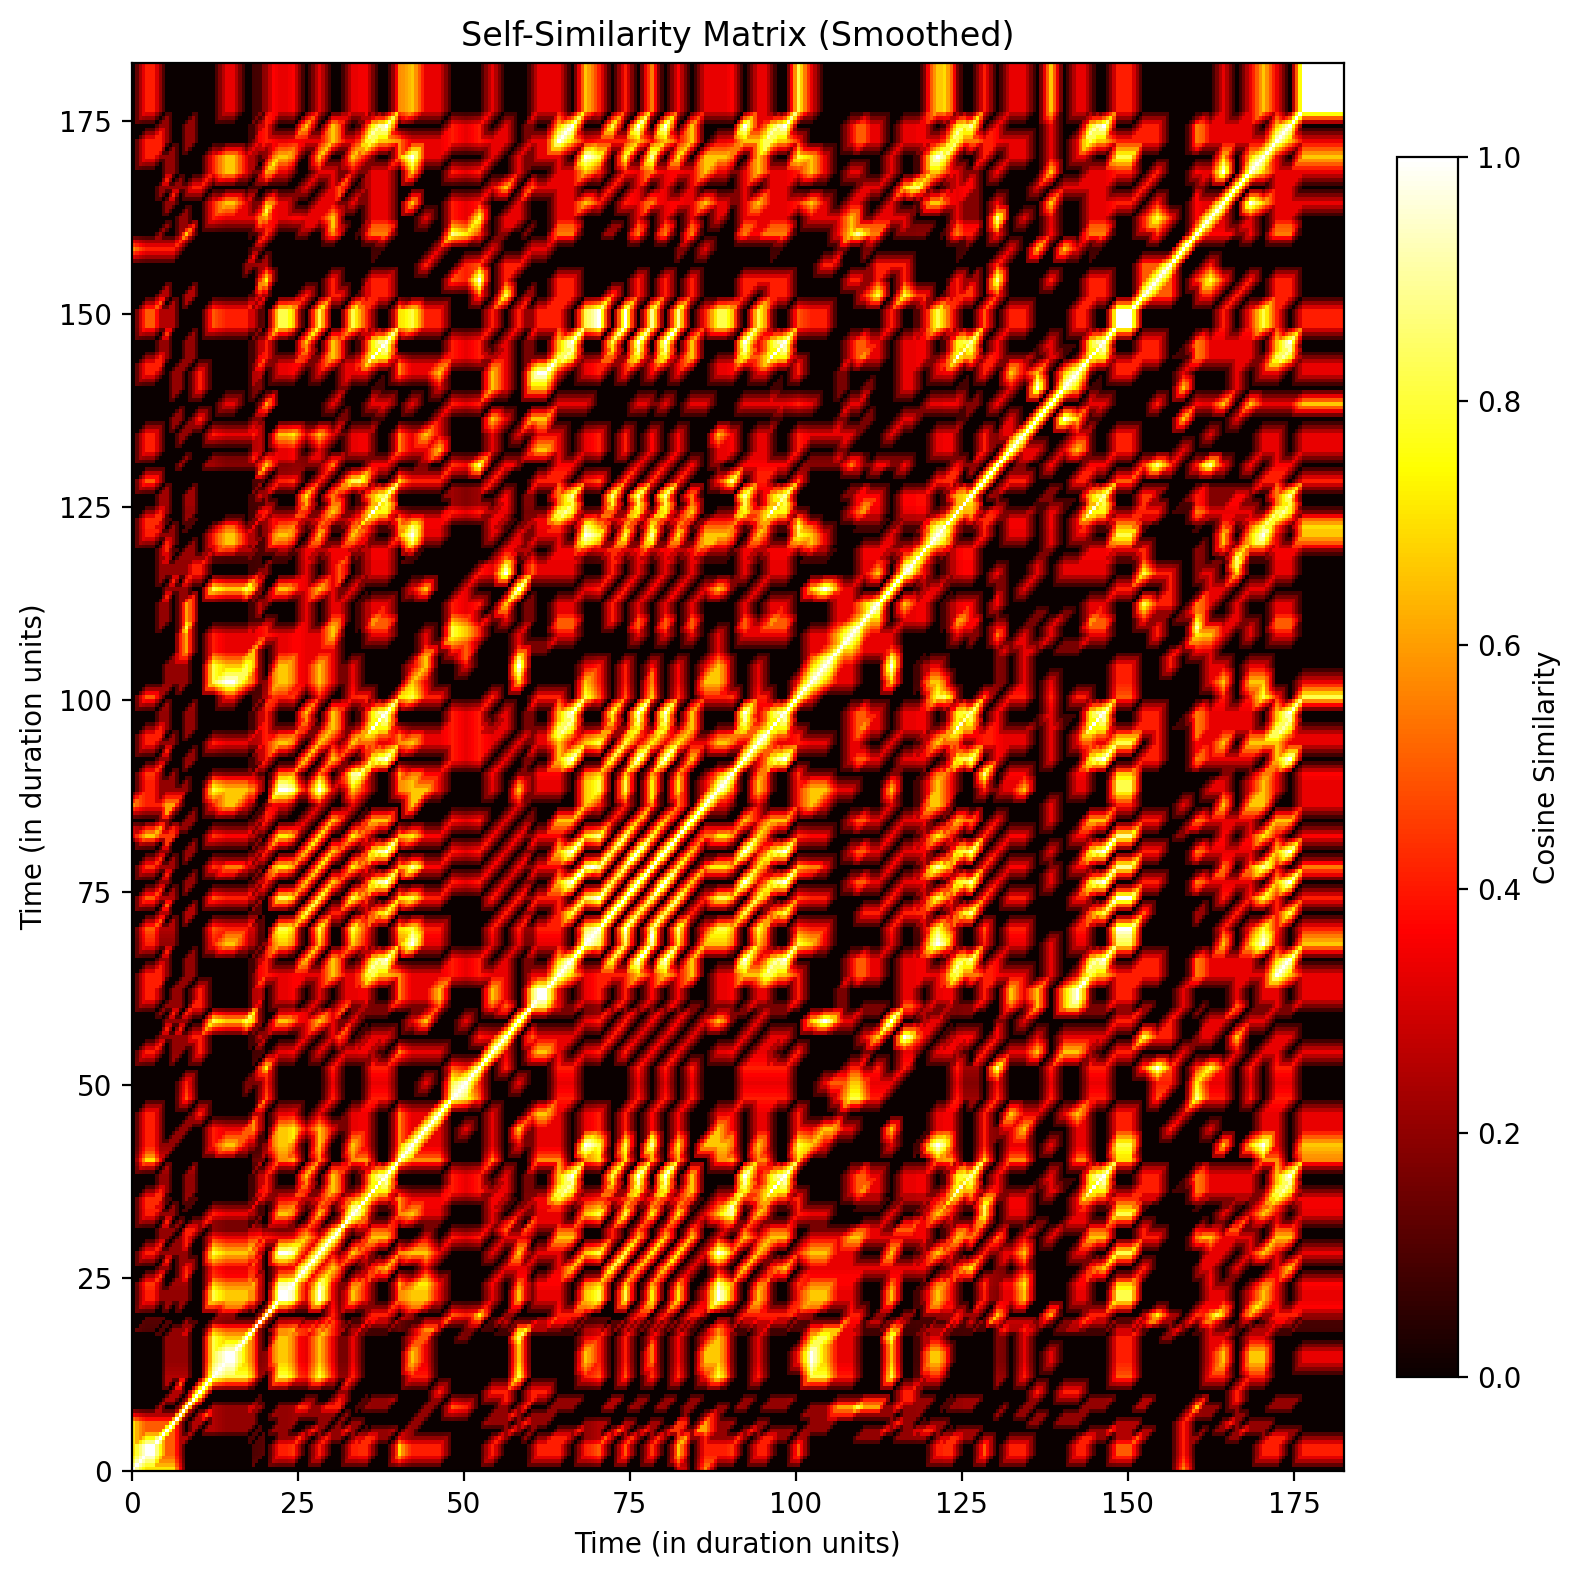

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.signal import convolve2d  # Required for diagonal smoothing

def diagonal_smooth(mat, width):
    """
    Apply diagonal smoothing to a matrix.

    Args:
        mat (np.ndarray): The input matrix to smooth.
        width (int): The width of the smoothing kernel. Must be a positive integer.

    Returns:
        np.ndarray: The diagonally smoothed matrix.
    """
    if width <= 1:
        return mat
    # Create a diagonal kernel
    kernel = np.eye(width) / width
    # Apply convolution along both axes to smooth diagonally
    smoothed = convolve2d(mat, kernel, mode='same', boundary='symm')
    return smoothed

def compute_windowed_ssm(binary_matrix, window_size=10, stride=1, smooth_width=None):
    """
    Computes the Self-Similarity Matrix (SSM) of a binary matrix using windowed cosine similarity,
    with optional diagonal smoothing.

    Parameters:
    - binary_matrix (np.ndarray): Binary matrix representation of the piano roll
                                   with shape (num_pitches, num_time_frames).
    - window_size (int): Number of consecutive time frames to include in each window.
    - stride (int): Number of time frames to move the window at each step.
    - smooth_width (int, optional): Width of the diagonal smoothing kernel. If None, no smoothing is applied.

    Returns:
    - ssm (np.ndarray): Self-Similarity Matrix with shape (num_windows, num_windows).
    """
    num_pitches, num_time_frames = binary_matrix.shape
    print(f"Binary matrix shape: {binary_matrix.shape}")

    # Transpose to have time frames as rows
    time_vectors = binary_matrix.T  # Shape: (num_time_frames, num_pitches)

    # Generate windowed vectors
    windowed_vectors = []
    window_indices = []
    for start in range(0, num_time_frames - window_size + 1, stride):
        window = time_vectors[start:start + window_size]
        window_vector = window.flatten()  # Flatten to create a single vector per window
        windowed_vectors.append(window_vector)
        window_indices.append(start)

    windowed_vectors = np.array(windowed_vectors)  # Shape: (num_windows, num_pitches * window_size)
    num_windows = windowed_vectors.shape[0]
    print(f"Number of windows: {num_windows}")

    # Normalize the window vectors to unit length
    norms = np.linalg.norm(windowed_vectors, axis=1, keepdims=True)
    norms[norms == 0] = 1.0  # Avoid division by zero
    normalized_vectors = windowed_vectors / norms

    # Compute cosine similarity between all window pairs
    print("Computing cosine similarity between windowed vectors...")
    ssm = cosine_similarity(normalized_vectors)

    # Ensure diagonal elements are exactly 1
    np.fill_diagonal(ssm, 1.0)

    # Apply diagonal smoothing if specified
    if smooth_width is not None and smooth_width > 1:
        print(f"Applying diagonal smoothing with width: {smooth_width}")
        ssm = diagonal_smooth(ssm, smooth_width)
        # After smoothing, ensure diagonal elements are still exactly 1
        np.fill_diagonal(ssm, 1.0)

    return ssm, window_size, stride, window_indices

def visualize_ssm(ssm, resolution, window_size, stride, title='Self-Similarity Matrix (Windowed Cosine Similarity)'):
    """
    Visualizes the Self-Similarity Matrix using matplotlib.

    Parameters:
    - ssm (np.ndarray): Self-Similarity Matrix.
    - resolution (float): Time resolution used in the binary matrix.
    - window_size (int): Number of time frames in each window.
    - stride (int): Stride used when sliding the window.
    - title (str): Title of the plot.
    """
    num_windows = ssm.shape[0]
    extent = [0, num_windows * stride * resolution, 0, num_windows * stride * resolution]

    # Create a figure with a fixed aspect ratio to ensure it's rectangular
    fig, ax = plt.subplots(figsize=(8, 8))  # Adjust figsize as needed for clarity

    # Display the SSM
    cax = ax.imshow(ssm, origin='lower', cmap='hot', interpolation='nearest', aspect='auto', extent=extent)

    # Set labels and title
    ax.set_xlabel('Time (in duration units)')
    ax.set_ylabel('Time (in duration units)')
    ax.set_title(title)

    # Add colorbar without affecting the figure size
    cbar = fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Cosine Similarity')

    # Ensure the plot is exactly rectangular
    plt.tight_layout()
    plt.show()

# Example Usage:

binary_matrix = binary_matrix_auto
resolution = res_auto


# Assuming `binary_matrix`, `resolution`, `lowest_midi`, and `highest_midi` are already defined
# from the previous cell where you created the binary matrix.

# Parameters
window_size = 4    # Number of time frames per window
stride = 1          # Move window by 1 time frame at each step
smooth_width = 1    # Width of the diagonal smoothing kernel

# Compute the Self-Similarity Matrix with Diagonal Smoothing
ssm, used_window_size, used_stride, window_indices = compute_windowed_ssm(
    binary_matrix,
    window_size=window_size,
    stride=stride,
    smooth_width=smooth_width
)

# Visualize the SSM
visualize_ssm(ssm, resolution, used_window_size, used_stride, title='Self-Similarity Matrix (Smoothed)')


In [4]:
from bokeh.plotting import figure, show
from bokeh.models import ColorBar, LinearColorMapper
from bokeh.io import output_notebook
from bokeh.transform import linear_cmap
from bokeh.layouts import column
import numpy as np

# Ensure Bokeh outputs directly to the notebook
output_notebook()

def visualize_ssm_bokeh(ssm, resolution, window_size, stride, title='Self-Similarity Matrix (Windowed Cosine Similarity)'):
    """
    Visualizes the Self-Similarity Matrix using Bokeh.

    Parameters:
    - ssm (np.ndarray): Self-Similarity Matrix.
    - resolution (float): Time resolution used in the binary matrix.
    - window_size (int): Number of time frames in each window.
    - stride (int): Stride used when sliding the window.
    - title (str): Title of the plot.
    """
    num_windows = ssm.shape[0]
    extent = [0, num_windows * stride * resolution, 0, num_windows * stride * resolution]

    # Create the figure
    plot = figure(title=title, x_axis_label='Time (in duration units)', y_axis_label='Time (in duration units)',
                  x_range=(extent[0], extent[1]), y_range=(extent[2], extent[3]),
                  width=900, height=900)

    # Set up the color mapper
    mapper = LinearColorMapper(palette="Magma256", low=np.min(ssm), high=np.max(ssm))

    # Display the SSM using image
    plot.image(image=[ssm], x=extent[0], y=extent[2], dw=extent[1] - extent[0], dh=extent[3] - extent[2], color_mapper=mapper)

    # Add a color bar
    color_bar = ColorBar(color_mapper=mapper, location=(0, 0), title="Cosine Similarity")
    plot.add_layout(color_bar, 'right')

    # Show the plot
    show(plot)

# Parameters
window_size = 4    # Number of time frames per window
stride = 1          # Move window by 1 time frame at each step
smooth_width = 2    # Width of the diagonal smoothing kernel

# Compute the Self-Similarity Matrix with Diagonal Smoothing
ssm, used_window_size, used_stride, window_indices = compute_windowed_ssm(
    binary_matrix,
    window_size=window_size,
    stride=stride,
    smooth_width=smooth_width
)

# Example Usage (assuming binary_matrix, resolution, window_size, etc., are defined):
visualize_ssm_bokeh(ssm, resolution, used_window_size, used_stride, title='Self-Similarity Matrix (Smoothed)')


Loading BokehJS ...

Binary matrix shape: (27, 368)
Number of windows: 365
Computing cosine similarity between windowed vectors...
Applying diagonal smoothing with width: 2
